# Review Analysis

## Data Preparation

In [1]:
import pandas as pd
import seaborn as sns
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import jsonlines
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

### Clean business dataset 

In [2]:
data = []
with jsonlines.open("yelp/yelp_academic_dataset_business.json") as reader:
    for obj in reader:
        data.append(obj)

business = pd.DataFrame(data)
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [4]:
## select restaurants in USA
us_restaurants = usa.dropna(subset=['categories'])
us_restaurants = us_restaurants[us_restaurants['categories'].str.contains('Restaurants')]

## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants.category[:20]

3            NaN
5            NaN
8          Greek
9            NaN
11    Vietnamese
12      American
14       Italian
15      Japanese
19        Korean
22           NaN
23       Italian
24           NaN
27      Japanese
28       Italian
29           NaN
31           NaN
33           NaN
35      American
36           NaN
41       Italian
Name: category, dtype: object

In [5]:
## drop null values, delete original column 
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,hours,category
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...",None,Greek
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",Vietnamese
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"{'RestaurantsReservations': 'False', 'Restaura...","{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",American
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'OutdoorSeating': 'False', 'RestaurantsGoodFo...","{'Monday': '10:0-18:0', 'Tuesday': '10:0-20:0'...",Italian
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-...",Japanese
5,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",Korean
6,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Italian
7,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,"{'RestaurantsGoodForGroups': 'True', 'HappyHou...","{'Wednesday': '16:0-22:0', 'Thursday': '16:0-2...",Japanese
8,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'Smoking': 'u'no'', 'NoiseLevel': 'u'average'...","{'Monday': '16:0-0:0', 'Tuesday': '16:0-0:0', ...",Italian
9,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","{'Monday': '0:0-0:0', 'Wednesday': '16:0-22:0'...",American


In [6]:
## check total number of us restaurants
us_restaurants.shape

(28450, 14)

In [7]:
## check missing values
us_restaurants.isnull().sum()

business_id        0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       228
hours           3414
category           0
dtype: int64

### Clean yelp_review dataset

In [8]:
## load review table
data2 = []
with jsonlines.open("yelp/yelp_academic_dataset_review.json") as reader:
    for obj in reader:
        data2.append(obj)

review = pd.DataFrame(data2)
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


### Merge two datasets and get new dataframe restaurants_reviews

In [9]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
    

In [10]:
## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

In [11]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >3, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neutral'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easier analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neutral'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,...,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,9fmAJ76g2-CKbbU14Ai1aw,LNprC9Mi8Xqtgk1KCFlKAg,4.0,0,0,0,"I like Tsevis because they have good gyros, wh...",2014-02-25 22:34:59,53,positive
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,OCmjANuYad62GAyY0NI8bQ,z-i_Qv-E3qeHfdPZddpwYQ,4.0,0,0,0,Good Greek American food. I highly recomend th...,2013-01-29 04:27:04,26,positive
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,QPZ66Xk54CprqZgTW1QTdQ,m6YhwUNoehMm6s52w9A4eA,2.0,0,0,0,Wife and I have eaten lunch here a few times o...,2013-10-25 15:39:01,184,negative
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,yUpKEiSWjcix-zWHFMT39w,-YAnRx8VSDkASxlylv3dyg,1.0,0,0,0,After about 7 minutes of waiting patiently for...,2014-07-16 19:17:34,189,negative
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,JR0MWE4psJqD2MyHbMckxA,WJ-veSDe63t0HnCu2E1NSA,1.0,3,0,0,Three of us decided to try this place out last...,2012-12-17 18:37:23,224,negative


## Review Analysis

### Positive words and negative words

In [12]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [13]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


In [14]:
## import positive file which contains common positive words such as good
filePositive = open('positive.txt')
reader = csv.reader(filePositive)
positive_words = [word[0] for word in reader]

## import negative file which contains common negative words such as bad
fileNegative = open('negative.txt')
reader = csv.reader(fileNegative)
negative_words = [word[0] for word in reader]

In [15]:
## function to get a sub-dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## function to only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

### We use Mexican food for this example to demonstrate the steps

In [16]:
Mexican_reviews = get_dataset('Mexican')

In [17]:
Mexican_train, Mexican_test = train_test_split(Mexican_reviews[['text','labels']],test_size=0.5)

In [18]:
print('Total %d number of reviews' % Mexican_train.shape[0])

Total 181151 number of reviews


In [19]:
# function to make the train test split 
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [20]:
## filter words
Mexican_train.text = Mexican_train.text.apply(filter_words)

In [21]:
## construct features and labels
terms_train=list(Mexican_train['text'])
class_train=list(Mexican_train['labels'])

terms_test=list(Mexican_test['text'])
class_test=list(Mexican_test['labels'])

In [22]:
## vectorizer to count the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape

(181151, 4416)

In [23]:
## run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

Support Vector Machine (SVM) model was applied to differentiate positive and
negative words in reviews, and further to get a word score to understand how positive or how negative the words are to figure out their importance in a review.

### Now we can calculate get a polarity score of each word in the category (Mexican)

### Mexican

In [24]:
## create dataframe for score of each word in a review calculated by svm model
coeff = svm.coef_[0]
feature_names = vectorizer.get_feature_names_out()
Mexican_words_score = pd.DataFrame({'score': coeff, 'word': feature_names})

In [25]:
## get frequency of each word in all reviews in specific category
Mexican_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names_out())
Mexican_reviews['labels'] = class_train
Mexican_frequency = Mexican_reviews[Mexican_reviews['labels'] =='positive'].sum()[:-1]

In [26]:
Mexican_words_score.set_index('word', inplace=True)

In [27]:
Mexican_polarity_score = Mexican_words_score
Mexican_polarity_score['frequency'] = Mexican_frequency

*polarity score
is a value that reflects the polarity of a particular
sentiment towards each restaurant category, the sentiment
score of each word was first multiplied by its frequency, and
then normalized by the total number of reviews for the specific
category of restaurants.*

In [28]:
## calculate polarity score 
Mexican_polarity_score['polarity'] = Mexican_polarity_score.score * Mexican_polarity_score.frequency / Mexican_reviews.shape[0]

In order to find specific words that were used to indicate
customers’ concerns for the restaurant, or by moving forward
exploring the unique characteristic of each restaurant category,
adjectives that simply describing the polarity of sentiment (i.e.
“good”, “amazing”, “terrible” and etc.) were neglected.

In [29]:
## drop unnecessary words
unuseful_positive_words = Mexican_polarity_score.loc[['great','amazing','love','best','awesome','excellent','good',
                                                    'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']]
unuseful_negative_words =  Mexican_polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible',
                                                     'lacking','terrible','sorry', 'disappoint']]

Mexican_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Mexican_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [30]:
Mexican_polarity_score.polarity = Mexican_polarity_score.polarity.astype(float)
Mexican_polarity_score.frequency = Mexican_polarity_score.frequency.astype(float)

In [31]:
Mexican_polarity_score[Mexican_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:20]

,score,frequency,polarity
word,,,
delicious,0.546,16276.000,0.049
fresh,0.288,18155.000,0.029
friendly,0.311,15113.000,0.026
recommend,0.190,12650.000,0.013
authentic,0.168,11161.000,0.010
die,0.667,2142.000,0.008
fun,0.290,4769.000,0.008
variety,0.359,3096.000,0.006
pleasantly,0.878,1217.000,0.006


#### Get top 10 most informative positive and negative words

In [33]:
Mexican_top_positive_words = ['delicious','friendly','attentive','recommend','fresh','variety','reasonable','tender','clean','authentic']
Mexican_top_negative_words = ['bland','slow','expensive','overpriced', 'cold', 'greasy','sweet','fatty','rude','dirty']
Mexican_top_words = Mexican_polarity_score.loc[Mexican_top_positive_words+Mexican_top_negative_words,'polarity']

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06]),
 [Text(-0.01, 0, '−0.01'),
  Text(0.0, 0, '0.00'),
  Text(0.01, 0, '0.01'),
  Text(0.019999999999999997, 0, '0.02'),
  Text(0.03, 0, '0.03'),
  Text(0.04, 0, '0.04'),
  Text(0.049999999999999996, 0, '0.05'),
  Text(0.060000000000000005, 0, '0.06')])

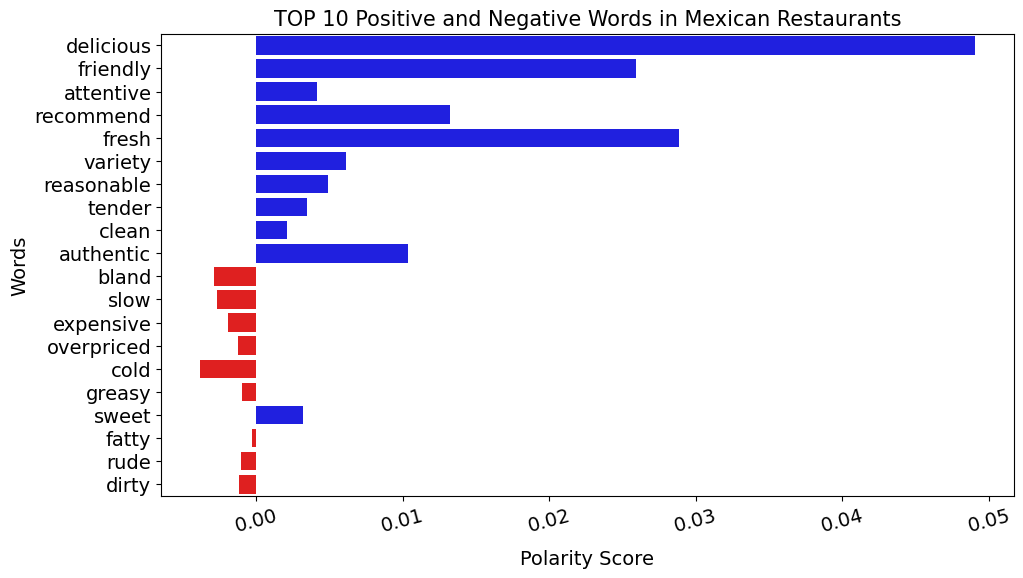

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(11,6))
colors = ['red' if c < 0 else 'blue' for c in Mexican_top_words.values]
sns.barplot(y=Mexican_top_words.index, x=Mexican_top_words.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 10 Positive and Negative Words in Mexican Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)

In [36]:
# general function to get polarity scores for a certain category
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names_out()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names_out())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']
    unuseful_negative_words =  ['bad','disappointed','unfortunately','disappointing','horrible',
                                                    'lacking','terrible','sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score

In [37]:
# general function to get the top words in a certain cuisine
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df

In [38]:
# general function to plot the most influential words in the cuisine reviews
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)

#### Japanese Cuisine Word Classification

In [39]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.9)
print('Total %d number of reviews' % Japanese_train.shape[0])

Total 13683 number of reviews


In [40]:
Japanese_polarity_score = get_polarity_score(Japanese_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
get_top_words(Japanese_polarity_score, 'positive')

,score,frequency,polarity
word,,,
delicious,0.648,1142,0.054
fresh,0.308,1831,0.041
friendly,0.279,1117,0.023
recommend,0.181,1248,0.017
fun,0.556,352,0.014
liked,0.409,305,0.009
pleasantly,1.047,112,0.009
enjoy,0.232,407,0.007
reasonable,0.343,267,0.007


In [42]:
get_top_words(Japanese_polarity_score,'negative',20)

,score,frequency,polarity
word,,,
wrong,-0.519,119,-0.005
cold,-0.302,170,-0.004
slow,-0.320,144,-0.003
expensive,-0.256,150,-0.003
hard,-0.112,304,-0.002
work,-0.134,243,-0.002
warm,-0.183,160,-0.002
bland,-0.888,32,-0.002
lack,-0.543,52,-0.002


In [43]:
Japanese_top_positive_words = ['delicious','friendly','fresh','recommend','fun','reasonable',
                               'creative','clean','variety','attentive']
Japanese_top_negative_words = ['hard','cold','wrong','slow','bland','dark','expensive',
                               'rude','overpriced','crowded']
Japanese_top_words = Japanese_polarity_score.loc[Japanese_top_positive_words+Japanese_top_negative_words,'polarity']

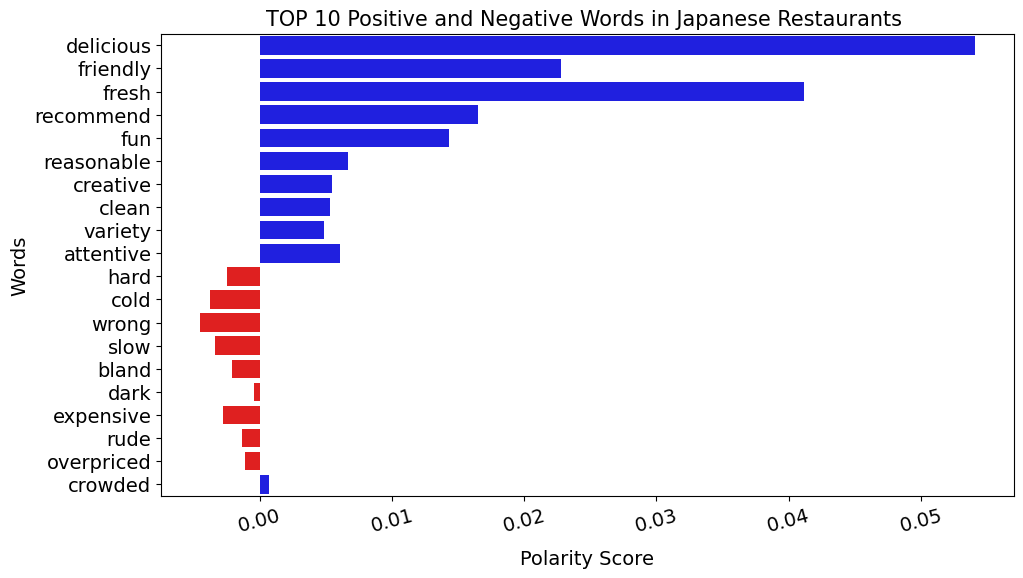

In [44]:
plot_top_words(Japanese_top_words,'Japanese')

#### Thai Cuisine Word Classification

In [45]:
Thai_reviews = get_dataset('Thai')
Thai_train = split_data(Thai_reviews, 0.9)
print('Total %d number of reviews' % Thai_train.shape[0])

Total 8986 number of reviews


In [46]:
Thai_polarity_score = get_polarity_score(Thai_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [47]:
get_top_words(Thai_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.382,965,0.041
friendly,0.388,787,0.034
fresh,0.208,936,0.022
reasonable,0.733,190,0.015
recommend,0.162,775,0.014
hot,0.146,604,0.010
fried,0.054,1360,0.008
helpful,0.720,101,0.008
fast,0.304,237,0.008


In [48]:
get_top_words(Thai_polarity_score,'negative')

,score,frequency,polarity
word,,,
hard,-0.215,167,-0.004
wrong,-0.329,109,-0.004
sour,-0.222,151,-0.004
bland,-0.857,35,-0.003
cold,-0.372,78,-0.003
hate,-0.876,27,-0.003
lack,-0.873,24,-0.002
seasoned,-0.349,53,-0.002
fairly,-0.218,79,-0.002


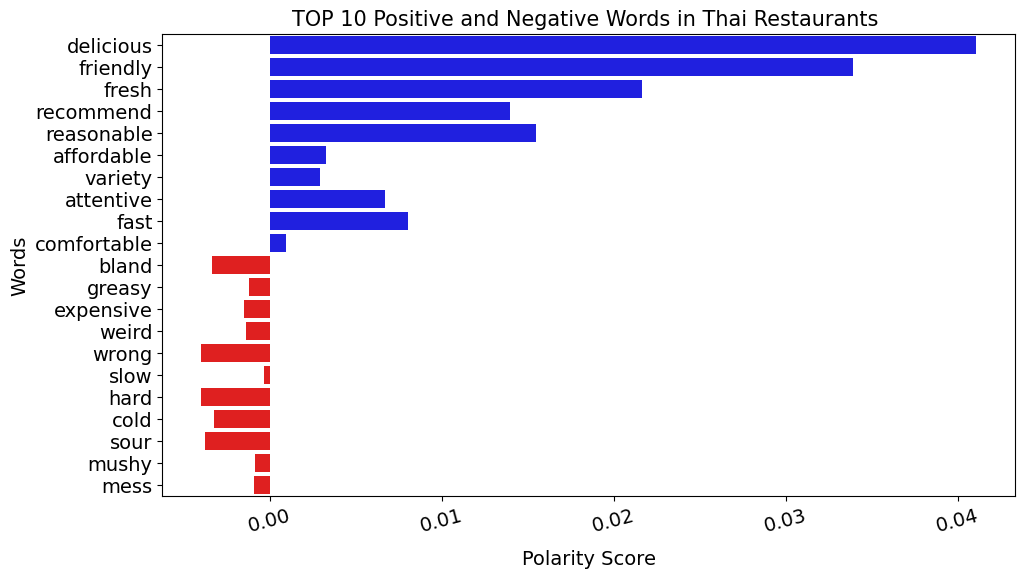

In [49]:
Thai_top_positive_words = ['delicious','friendly','fresh','recommend','reasonable','affordable','variety',
                           'attentive','fast','comfortable']
Thai_top_negative_words = ['bland','greasy','expensive','weird','wrong','slow','hard','cold','sour','mushy','mess']
Thai_top_words = Thai_polarity_score.loc[Thai_top_positive_words+Thai_top_negative_words,'polarity']
plot_top_words(Thai_top_words, 'Thai')

#### Chinese Cuisine Word Classification

In [50]:
Chinese_reviews = get_dataset('Chinese')
Chinese_train = split_data(Chinese_reviews, 0.85)
print('Total %d number of reviews' % Chinese_train.shape[0])

Total 23057 number of reviews


In [51]:
Chinese_polarity_score = get_polarity_score(Chinese_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [52]:
get_top_words(Chinese_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.638,1666,0.046
friendly,0.415,1502,0.027
fresh,0.284,1947,0.024
hot,0.169,2524,0.018
authentic,0.299,1059,0.014
recommend,0.175,1707,0.013
pleasantly,1.293,196,0.011
fast,0.227,880,0.009
fun,0.285,585,0.007


In [53]:
get_top_words(Chinese_polarity_score,'negative')

,score,frequency,polarity
word,,,
sour,-0.149,1084,-0.007
cold,-0.432,344,-0.006
hard,-0.235,460,-0.005
fried,-0.022,3375,-0.003
wrong,-0.274,253,-0.003
bland,-0.760,89,-0.003
expensive,-0.347,164,-0.002
greasy,-0.256,206,-0.002
poor,-0.963,48,-0.002


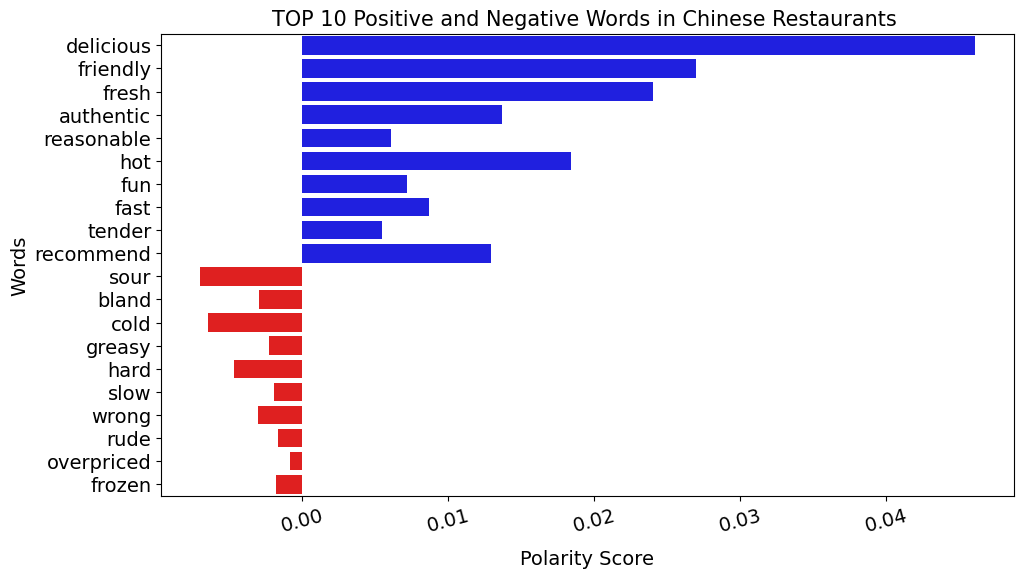

In [54]:
Chinese_top_positive_words = ['delicious','friendly','fresh','authentic','reasonable','hot','fun',
                           'fast','tender','recommend']
Chinese_top_negative_words = ['sour','bland','cold','greasy','hard','slow','wrong','rude','overpriced','frozen']
Chinese_top_words = Chinese_polarity_score.loc[Chinese_top_positive_words+Chinese_top_negative_words,'polarity']
plot_top_words(Chinese_top_words, 'Chinese')

#### Vietnamese Cuisine Word Classification

In [55]:
Vietnamese_reviews = get_dataset('Vietnamese')
Vietnamese_train = split_data(Vietnamese_reviews, 0.7)
print('Total %d number of reviews' % Vietnamese_train.shape[0])

Total 22262 number of reviews


In [56]:
Vietnamese_polarity_score = get_polarity_score(Vietnamese_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [57]:
get_top_words(Vietnamese_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.577,2359,0.061
fresh,0.279,3172,0.040
friendly,0.389,2017,0.035
tender,0.708,386,0.012
recommend,0.149,1688,0.011
solid,0.839,268,0.010
generous,0.516,397,0.009
reasonable,0.428,438,0.008
fast,0.226,778,0.008


In [58]:
get_top_words(Vietnamese_polarity_score,'negative')

,score,frequency,polarity
word,,,
fried,-0.061,1921,-0.005
bland,-0.882,82,-0.003
wrong,-0.262,271,-0.003
sour,-0.271,255,-0.003
slow,-0.336,187,-0.003
hard,-0.113,510,-0.003
sad,-0.574,77,-0.002
mediocre,-1.067,39,-0.002
weird,-0.440,94,-0.002


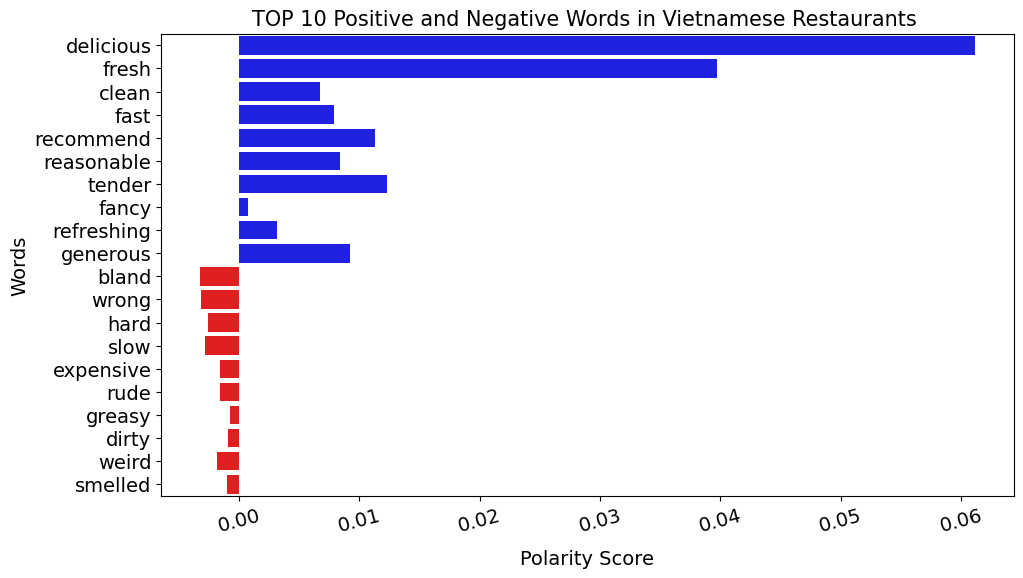

In [60]:
Vietnamese_top_positive_words = ['delicious','fresh','clean','fast','recommend','reasonable','tender',
                           'fancy','refreshing','generous']
Vietnamese_top_negative_words = ['bland','wrong','hard','slow','expensive','rude','greasy','dirty','weird','smelled']
Vietnamese_top_words = Vietnamese_polarity_score.loc[Vietnamese_top_positive_words+Vietnamese_top_negative_words,'polarity']
plot_top_words(Vietnamese_top_words,'Vietnamese')

#### French Cuisine Word Classification

In [61]:
French_reviews = get_dataset('French')
French_train = split_data(French_reviews, 0.7)
print('Total %d number of reviews' % French_train.shape[0])

Total 23977 number of reviews


In [62]:
French_polarity_score = get_polarity_score(French_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [63]:
get_top_words(French_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.432,3025,0.054
fresh,0.217,1941,0.018
friendly,0.199,1795,0.015
recommend,0.137,2234,0.013
sweet,0.172,1487,0.011
attentive,0.260,951,0.010
die,0.464,532,0.010
lovely,0.231,817,0.008
rich,0.328,573,0.008


In [64]:
get_top_words(French_polarity_score, 'negative')

,score,frequency,polarity
word,,,
cold,-0.548,324,-0.007
hard,-0.179,594,-0.004
slow,-0.393,239,-0.004
wrong,-0.228,371,-0.004
expensive,-0.212,286,-0.003
worked,-0.266,197,-0.002
dirty,-0.467,106,-0.002
clearly,-0.364,136,-0.002
bland,-0.915,53,-0.002


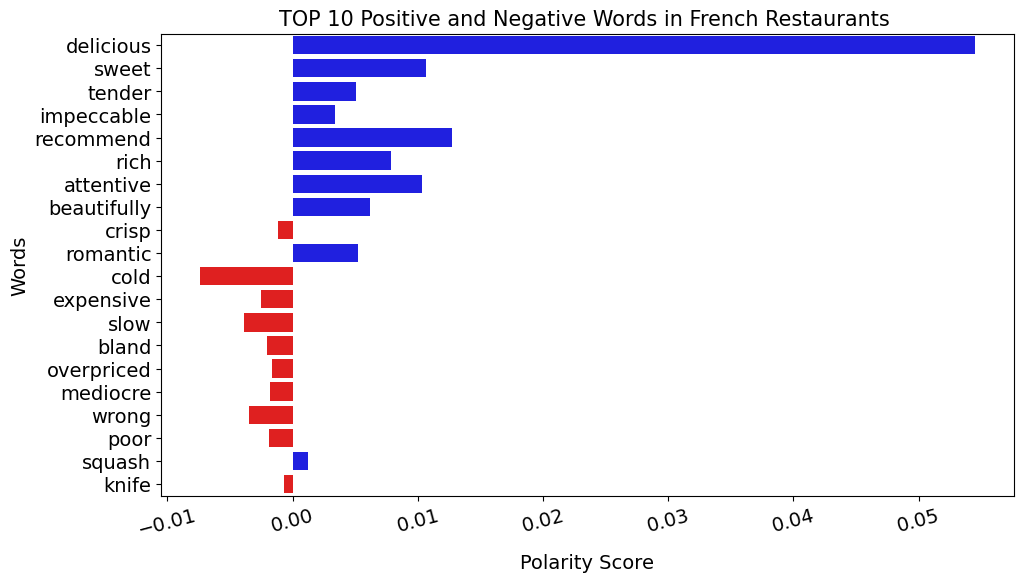

In [65]:
French_top_positive_words = ['delicious','sweet','tender','impeccable','recommend','rich','attentive',
                             'beautifully','crisp','romantic']
French_top_negative_words = ['cold','expensive','slow','bland','overpriced','mediocre','wrong',
                             'poor','squash','knife']
French_top_words = French_polarity_score.loc[French_top_positive_words+French_top_negative_words,'polarity']
plot_top_words(French_top_words,'French')

#### Italian Cuisine Word Classification

In [66]:
Italian_reviews = get_dataset('Italian')
Italian_train = split_data(Italian_reviews, 0.9)
print('Total %d number of reviews' % Italian_train.shape[0])

Total 35277 number of reviews


In [67]:
Italian_polarity_score = get_polarity_score(Italian_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [68]:
get_top_words(Italian_polarity_score, 'positive',30)

,score,frequency,polarity
word,,,
delicious,0.598,3369,0.057
friendly,0.308,2794,0.024
fresh,0.240,3236,0.022
recommend,0.197,2558,0.014
die,0.742,603,0.013
authentic,0.491,815,0.011
reasonable,0.455,528,0.007
variety,0.529,444,0.007
incredible,0.602,384,0.007


In [69]:
get_top_words(Italian_polarity_score, 'negative',30)

,score,frequency,polarity
word,,,
cold,-0.483,361,-0.005
hard,-0.212,714,-0.004
wrong,-0.208,457,-0.003
slow,-0.392,219,-0.002
clearly,-0.479,151,-0.002
expensive,-0.312,209,-0.002
frozen,-0.538,118,-0.002
bland,-0.802,76,-0.002
poor,-0.876,68,-0.002


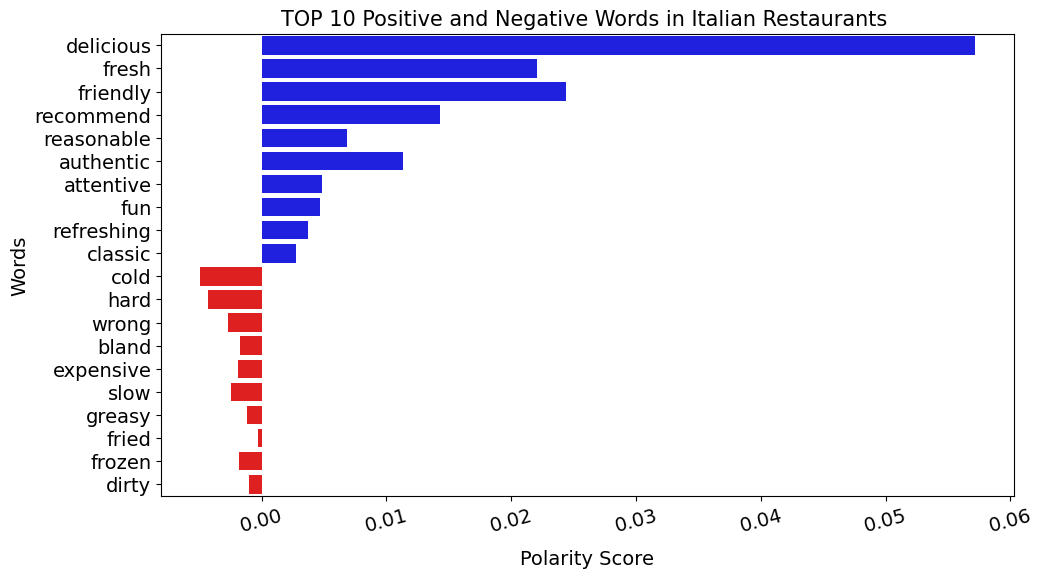

In [70]:
Italian_top_positive_words = ['delicious','fresh','friendly','recommend','reasonable','authentic',
                             'attentive','fun','refreshing','classic']
Italian_top_negative_words = ['cold','hard','wrong','bland','expensive','slow','greasy','fried','frozen','dirty']
Italian_top_words = Italian_polarity_score.loc[Italian_top_positive_words+Italian_top_negative_words,'polarity']
plot_top_words(Italian_top_words,'Italian')

### Combine all top words to compare among different cuisine typies

In [72]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_positive_words = pd.DataFrame(all_category)
for i,word in enumerate(Mexican_top_positive_words):
    cuisine_positive_words.loc[0,i] = word

In [74]:
for i,word in enumerate(Mexican_top_positive_words):
    cuisine_positive_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_positive_words):
    cuisine_positive_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_positive_words):
    cuisine_positive_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_positive_words):
    cuisine_positive_words.iloc[3,i] = word
for i,word in enumerate(Vietnamese_top_positive_words):
    cuisine_positive_words.iloc[4,i] = word
for i,word in enumerate(French_top_positive_words):
    cuisine_positive_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_positive_words):
    cuisine_positive_words.iloc[6,i] = word

cuisine_positive_words.drop(9,axis=1,inplace=True)
cuisine_positive_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_positive_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_positive_words.set_index('cuisine', inplace=True)

In [76]:
all_category = {'cuisine':['Mexican','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_negative_words = pd.DataFrame(all_category)
for i,word in enumerate(Mexican_top_negative_words):
    cuisine_negative_words.loc[0,i] = word

In [79]:
for i,word in enumerate(Mexican_top_negative_words):
    cuisine_negative_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_negative_words):
    cuisine_negative_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_negative_words):
    cuisine_negative_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_negative_words):
    cuisine_negative_words.iloc[3,i] = word
for i,word in enumerate(Vietnamese_top_negative_words):
    cuisine_negative_words.iloc[4,i] = word
for i,word in enumerate(French_top_negative_words):
    cuisine_negative_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_negative_words):
    cuisine_negative_words.iloc[6,i] = word

cuisine_negative_words.drop(9,axis=1,inplace=True)
cuisine_negative_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_negative_words['cuisine']=['Mexican','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_negative_words.set_index('cuisine', inplace=True)

In [80]:
cuisine_positive_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,delicious,friendly,attentive,recommend,fresh,variety,reasonable,tender,clean,authentic
Japanese,delicious,friendly,fresh,recommend,fun,reasonable,creative,clean,variety,attentive
Chinese,delicious,friendly,fresh,authentic,reasonable,hot,fun,fast,tender,recommend
Thai,delicious,friendly,fresh,recommend,reasonable,affordable,variety,attentive,fast,comfortable
Vietnamese,delicious,fresh,clean,fast,recommend,reasonable,tender,fancy,refreshing,generous
French,delicious,sweet,tender,impeccable,recommend,rich,attentive,beautifully,crisp,romantic
Italian,delicious,fresh,friendly,recommend,reasonable,authentic,attentive,fun,refreshing,classic


In [81]:
cuisine_negative_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Mexican,bland,slow,expensive,overpriced,cold,greasy,sweet,fatty,rude,dirty
Japanese,hard,cold,wrong,slow,bland,dark,expensive,rude,overpriced,crowded
Chinese,sour,bland,cold,greasy,hard,slow,wrong,rude,overpriced,frozen
Thai,bland,greasy,expensive,weird,wrong,slow,hard,cold,sour,mushy
Vietnamese,bland,wrong,hard,slow,expensive,rude,greasy,dirty,weird,smelled
French,cold,expensive,slow,bland,overpriced,mediocre,wrong,poor,squash,knife
Italian,cold,hard,wrong,bland,expensive,slow,greasy,fried,frozen,dirty


# 6. Conclusion

Most restaurants prioritize deliciousness over other factors like service and price. Friendly service tends to drive high scores, particularly for Vietnamese and Italian cuisine, while freshness is valued in Vietnamese and Italian dishes. French restaurants excel in sweet dishes but Korean ones receive negative reviews for the same reason. Korean, Japanese, Chinese, and Thai establishments are praised for their friendly service, with Korean restaurants standing out for attentiveness. Japanese eateries are known for their fun and creative flair, while classic Italian dishes are preferred. French cuisine earns high scores for its romantic ambiance.

Korean, Thai, and Vietnamese restaurants face criticism for bland food, suggesting an expectation for spiciness. French, Italian, and Japanese eateries may receive low scores due to serving cold dishes. Japanese establishments also suffer from dim and crowded settings. Chinese cuisine is faulted for sour flavors, while Korean and French restaurants often face complaints about slow service. French cuisine's negative reviews may also stem from high prices, while Thai cuisine is criticized for greasy dishes.

Our analysis can help restaurant owners in getting key features from Yelp reviews, offering valuable insights into why customers love or dislike their establishments. They can identify factors such as fresh food driving positive reviews or high prices leading to dissatisfaction. Additionally, they can compare their restaurant with similar establishments within the same category.